python не был бы так популярен, если бы не библиотеки, расширяющие его функционал для выполнения практически любых задач. В рамках нашей специальности, нам нужно осваивать библиотеки для быстрых операций с массивами данных, построения математических моделей и их оптимизаций и визуализации некоторых материалов.

Этот раздел будет построен следующим образом:

Будет максимально короткое знакомство с библиотекой по типу:

1. Представление
2. 2 - 3 примера использования

Далее перейдем к решению практических задач и исследований, в ходе которых будем обращаться ко всем инструментам python и таким образом осваивая их.

Приведем краткий список тех библиотек, которые будут необходимы:
1. numpy - https://numpy.org/
2. pandas - https://pandas.pydata.org/
3. matplotlib - https://matplotlib.org/
4. sklearn - https://scikit-learn.org/stable/index.html
5. scipy - https://scipy.org/
6. statsmodels - https://www.statsmodels.org/stable/index.html
7. torch - https://pytorch.org/
8. jax - https://docs.jax.dev/en/latest/quickstart.html
9. polars - https://pola.rs/
10. plotly - https://plotly.com/

##### NUMPY

numpy - это библиотека, выполняющая векторизованные (https://ru.wikipedia.org/wiki/Векторизация_(параллельные_вычисления)) вычисления для массивов данных.
Она поддерживает также математические операции и работу с матрицами (по типу обращений, разложений, поиску собственных векторов и т.д.)

Параллельно мы сразу начнем использовать pandas, matplotlib и plotly для визуализации данных.
plotly в отличие от matplotlib позволяет строить интерактивные графики, правда, требует больше знаний и кода для его использования

In [2]:
# conventional aliases
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Длина траектории: 8767


Text(0, 0.5, 'S_t')

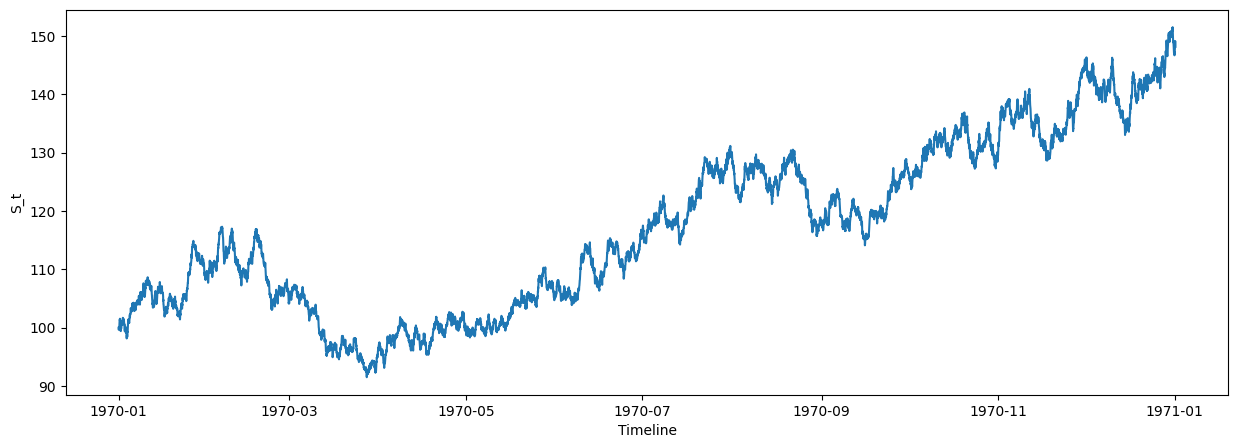

In [3]:
# простая задача для сравнения:
# сгенерировать 1000 траекторий GBM с шагом 1 час

from math import sqrt
import random

N: int = 365 * 24 + 6 # в 1 году 365 дней и 6 часов
timestep: float = 1 / N
S_0 = 100

# trivial approach
def GBM(
    S_0: float = S_0, mu: float = 0.1, sigma: float = 0.3, dt: float = timestep, n_steps: int = N
) -> list[float]:
    S: list[float] = [S_0]
    S_t = S_0
    sqrt_dt = sqrt(dt)
    for _ in range(n_steps):
        dW = random.normalvariate(0,1)
        dS = mu * S_t * dt + S_t * sqrt_dt * sigma * dW
        S.append(S_t:=S_t + dS)
    return S


S: list[float] = GBM()
print('Длина траектории:', len(S))

# сразу подготовим данные для отрисовки
# используем pandas для упаковки массива в структуру с осмысленной индексацией

# datarange позволяет строить массив данных в виде индексов времени, 
# в т.ч. дельты по времени, как ниже, с указанием начала, конца, шага
datarange: pd.DatetimeIndex = pd.timedelta_range(start='0min', end=f'{365 * 24 + 6}h', freq='1h')

# pd.Series как и pd.DataFrame -- ключевые объекты пандас, это столбец (Series) и матрица (DataFrame) соот-но
S = pd.Series(
    index=pd.to_datetime(0) + datarange,
    data=S
)

# создаем поле графика, указывая размер
plt.figure(figsize=(15,5))
# plt достаточно умен чтобы работать с Series и находить индексы
plt.plot(S)
# дополнения читабельности
plt.xlabel('Timeline')
plt.ylabel('S_t')

In [4]:
from typing import Any, Callable

# измерим скорость генерации траекторий
def generate_n_trajectories(path_generator: Callable[[Any], Any], n_paths: int) -> None:
    paths: list[list[float]] = list()
    for _ in range(n_paths):
        paths.append(path_generator())
    return paths

In [5]:
# напишем версию с np и с итератором
from itertools import islice

def np_GBM(
    S_0: float = S_0, mu: float = 0.1, sigma: float = 0.3, dt: float = timestep, n_steps: int = N
) -> list[float]:
    sqrt_dt = np.sqrt(dt)
    def price_iterator():
        yield (S_t := S_0)  # first iteration
        while True:
            dW = np.random.normal(0, 1)
            yield (S_t := S_t + mu * S_t * dt + S_t * sqrt_dt * sigma * dW)

    return np.fromiter(
        (S_t for S_t in islice(price_iterator(), n_steps)),
        dtype=np.float32
    )

In [6]:
# измерим скорость генерации одной траектории

In [7]:
%timeit GBM()

2.93 ms ± 659 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit np_GBM()

6.02 ms ± 55.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Задача: объяснить, почему версия с итератором и np работает медленнее
# Примечание: разбор задачи сгенерирован LLM моделями с пояснениями и реализацией

Hurst for white noise = 0.482862544875694


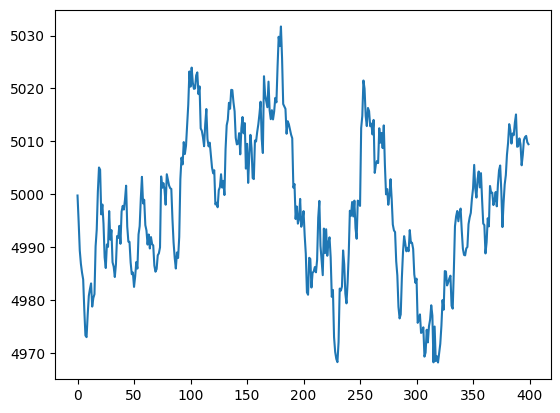

Hurst for persistent timeseries = 0.722841273103135


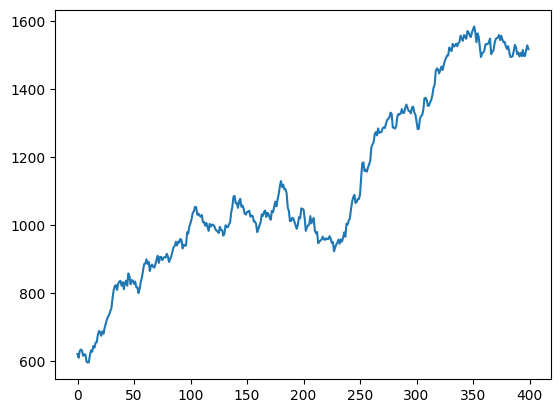

Hurst for persistent timeseries = 0.36240297690111345


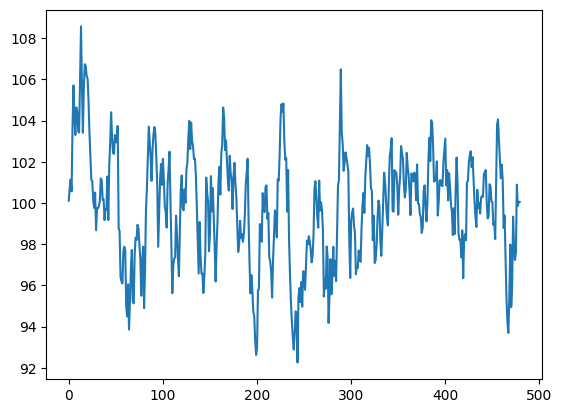

In [9]:
'''
    рассмотрим пример использования библиотеки numpy на примере аналзиза временного ряда.
    Ниже представлена функция, которая считает показатель Хёрста H - меру устойчивости тренда.
    (https://stochasticfractals.wordpress.com/2009/10/14/rs-analysis-to-estimate-the-hurst-exponent/)
    H определен на [0, 1], 
    H = 0.5 соответствует белому шуму без тренда, 
    H > 0.5 соответствует трендовому движению (без учета знака тренда)
    H < 0.5 соответствует mean-reversion процессу
'''

import numpy as np
import matplotlib.pyplot as plt


def hurst(ts: np.ndarray | list[float]) -> float | np.ndarray:
    npts = np.array(ts)
    logs = np.log(npts[:-1]/npts[1:])
    groups = np.arange(int(len(logs) / 10), 1, -1)
    RS = np.zeros(len(groups)+1)
    line = np.zeros(len(groups)+1)
    for group in groups:
        sub_RS = np.zeros(group)
        stdev = np.zeros(group)
        line[group-1] = len(logs)/group
        for sub in range(group):
            RSmax, RSmin = 0, 0
            sub_group = np.array(logs[int(len(logs)/group)*sub : int(len(logs)/group*(sub+1))])
            for in_sub in range(1, int(len(logs)/group)):
                sub_RS[sub] += sub_group[in_sub]
                RSmax = max(sub_RS[sub], RSmax)
                RSmin = min(sub_RS[sub], RSmin)
            sub_RS[sub] = RSmax - RSmin
            stdev[sub] = np.std(sub_group)
        a = sub_RS / stdev
        RS[group-1] = a.mean()
    poly = np.polyfit(np.log(line[1:]), np.log(RS[1:]), 1)
    H = poly[0] 
    return H 


white_noise = np.random.normal(0, 3, size=(500,)) + 100  # +10 т.к. функция берет логарифм от значений ряда!
conv_len = 50
# используем операцию свертки convolve, чтобы сгладить ряд! 
white_noise_smoothed = np.convolve(white_noise, np.ones((conv_len,)), mode='same')[conv_len:-conv_len]
print('Hurst for white noise =', hurst(white_noise_smoothed))
plt.plot(white_noise_smoothed)
plt.show()

persistent_ts = 0.05 * np.ones((500,)).cumsum() + np.random.normal(0,10,size=(500,)) + 10
persistent_ts_smoothed = np.convolve(persistent_ts, np.ones((conv_len,)), mode='same')[conv_len:-conv_len]
print('Hurst for persistent timeseries =', hurst(persistent_ts_smoothed))
plt.plot(persistent_ts_smoothed)
plt.show()

antipersistent_ts = np.random.normal(0,1,size=(500,)) + 10
conv_len = 10
antipersistent_ts_smoothed = np.convolve(antipersistent_ts, np.ones((conv_len,)), mode='same')[conv_len:-conv_len]
print('Hurst for persistent timeseries =', hurst(antipersistent_ts_smoothed))
plt.plot(antipersistent_ts_smoothed)
plt.show()


Задача: переписать функцию hurst, оптимизировав вычисления в numpy нотации.
Построить аппроксимацию зависимости логарифмов R/S отношения на графике.

In [114]:
import numpy as np

# зададим броуновские движения
brownian_motions_names: list[str] = ['A', 'B', 'C', 'D', 'E']
means: np.ndarray = np.random.uniform(0, 3, size=(len(brownian_motions_names),))


# положим что время наблюдений 5 лет
dt = 5.

# сгенерируем ковариационную матрицу
covariances: np.ndarray = np.random.normal(loc=0, scale=.5, size=(means.shape[0], means.shape[0])) ** 2
covariances = covariances @ covariances.T  # since covariance matrix is positive and symmetric!
covariances = covariances * dt

samples: np.ndarray = np.random.multivariate_normal(mean=means, cov=covariances, size=1_000_000)
correlations: np.ndarray = np.corrcoef(samples.T)
correlations

# задача: проверить, что матрица корреляции соответствует нормированной матрице ковариации
# assert np.isclose(normed_covariances, correlations).all()
# для какого количества наблюдений можно снизить относительную ошибку погрешности до 0.1% ? 


# ответ

# sigma = np.asarray([np.sqrt( covariances[i,i] / dt ) for i in range(covariances.shape[0])])
# print('sigma:', sigma)

# corrs = np.zeros((covariances.shape))
# for i, s1 in enumerate(sigma):
#     for j, s2 in enumerate(sigma):
#         corrs[i,j] = covariances[i,j] / s1 / s2 / dt
# assert np.isclose(corrs, correlations.values, rtol=1e-1).all(), 'Matrices are not equal!'

# задача: сгенерировать стохастические процессы с скоррелированными броуновскими движениями,
# но вручную с одномерным генератором случайных чисел, без использования multivariate_normal

array([[1.        , 0.22113838, 0.52273202, 0.58169944, 0.33663766],
       [0.22113838, 1.        , 0.23404412, 0.5811223 , 0.30859592],
       [0.52273202, 0.23404412, 1.        , 0.5801149 , 0.87883557],
       [0.58169944, 0.5811223 , 0.5801149 , 1.        , 0.27718389],
       [0.33663766, 0.30859592, 0.87883557, 0.27718389, 1.        ]])

Пример. Оптимизация портфеля по марковицу.

Пусть имеется N набор портфелей (альф), которые генерируют последовательности доходностей $r_{i,t}, i=\overline{1,N}, t\in[t_0,T]$, и вектор мат.ожидания доходностей $\Mu=(\mu_{i})_{i=1}^{N}$. Кроме того, эти временные ряды имеют матрицу ковариации $\Sigma=(\sigma_{i,j}), i,j=0,..,N$. На данном промежутке времени нужно построить портфель, то есть найти такой вектор $W=(w_1,..,w_N)$, максимизирующий метрику 
$$sharpe = \frac{\mathbb{E}[R]}{\mathbb{V}[R]} = \frac{W^T \Mu}{ \sqrt{ W^T \Sigma W } } \xrightarrow{W} max$$

Который достигается при $$W^* = \frac{\Sigma^{-1} \Mu}{ \mathbb{1} \Sigma^{-1} \Mu }$$

In [115]:
# сгенерируем несколько ABM процессов с скоррелированными броуновскими движениями, примем их как pnl ряд стратегий
# рассчитаем ковариации, мат.ожиданием для этих рядов и найдем вектор оптимальных весов

# используем сгенерированные ранее samples, чтобы получить оценку мат.ожидания
exp_returns: np.ndarray = np.mean(samples, axis=0)

# обращаем матрицу ковариаций
inverted_covariance_matrix: np.ndarray = np.linalg.inv(covariances)

# получаем оптимальные веса
w_optimal: np.ndarray = inverted_covariance_matrix @ exp_returns / (np.ones(exp_returns.shape) @ inverted_covariance_matrix @ exp_returns)
print('Вектор оптимальных весов портфеля:', w_optimal)
print('Проверка: сумма всех весов равна 1!\n', w_optimal.sum())
print('Значение Sharpe для портфеля =', w_optimal.T @ exp_returns / np.sqrt(w_optimal.T @ covariances @ w_optimal))

Вектор оптимальных весов портфеля: [ 0.01493284  0.58871132  2.62671597 -0.59099955 -1.63936058]
Проверка: сумма всех весов равна 1!
 1.0
Значение Sharpe для портфеля = 11.327426953280563


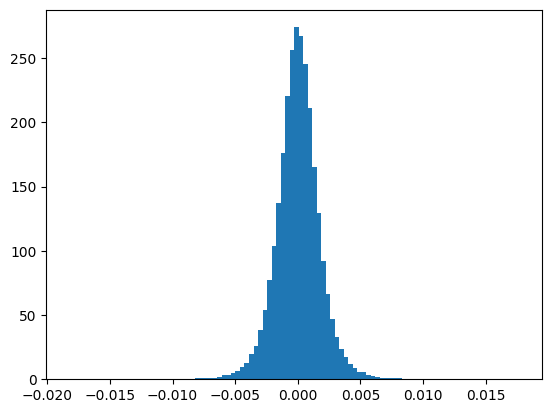

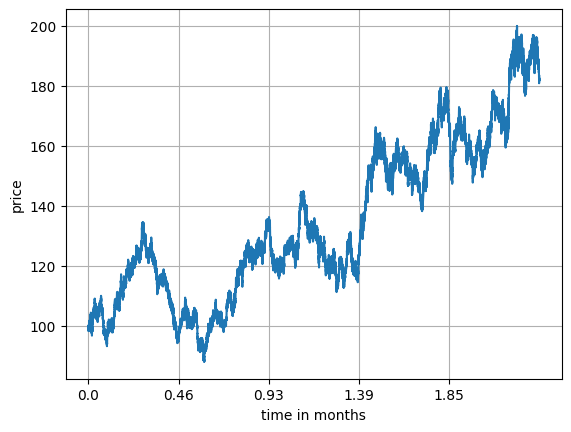

VaR 95% для портфеля в 100_000 рублей (с вероятностью 95% потери портфеля не более): 30183.32


In [131]:
# пример: расчет VaR для портфеля

# import numpy
from cProfile import label
import numpy as np
import matplotlib.pyplot as plt

# сгенерируем ряд из 100_000 значений, распределенных по закону Стьюдента с 5 степенями свободы
# и используем в качестве распределения доходностей с более толстыми хвостами чем у нормального распределения
N: int = 100_000
dT = np.random.standard_t(5, N) + 1e-3  # добавляем небольшое положительное смещение
returns = dT * np.sqrt(1 / 365.25 / 24 / 60)  # распределение ретурнов для 1 минуты


plt.hist(returns, bins = 100, density = True)
plt.show()

S_0: int = 100
some_price_movements = S_0 * np.exp(returns.cumsum())
plt.plot(some_price_movements)
plt.grid()
plt.xlabel('time in months')
plt.ylabel('price')
plt.xticks(range(0, N, 20_000), labels=np.round(np.arange(0, N, 20_000) / 60 / 24 / 30, 2))
plt.show()

# Monte Carlo VaR с векторизацией
def vectorized_var(returns: np.ndarray, confidence_level: float = 0.95, 
                   n_simulations: int = 1_000) -> float:
    """Vectorized Value at Risk calculation"""
    portfolio_returns = np.random.choice(returns, size=(n_simulations, len(returns)))
    portfolio_pnl = np.sum(portfolio_returns, axis=1)
    return np.percentile(portfolio_pnl, (1 - confidence_level) * 100)

# рассчитаем VaR для портфеля в 100_000 рублей
P_0: int = 100_000
var = vectorized_var(returns)
print(f'VaR 95% для портфеля в 100_000 рублей (с вероятностью 95% потери портфеля не более): {( 1 - np.exp(var) ) * P_0:.2f}')

sigma: [1.15713102 0.57104444 0.32764134 0.86285445 0.42236526]


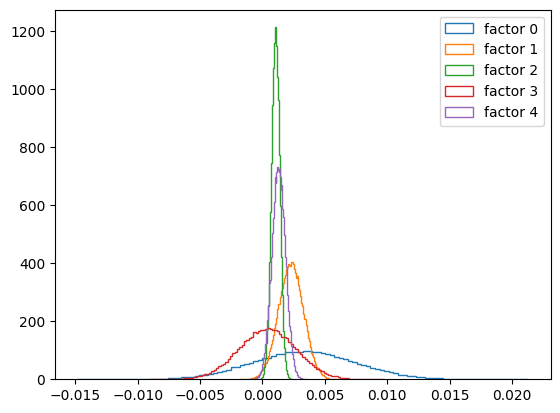

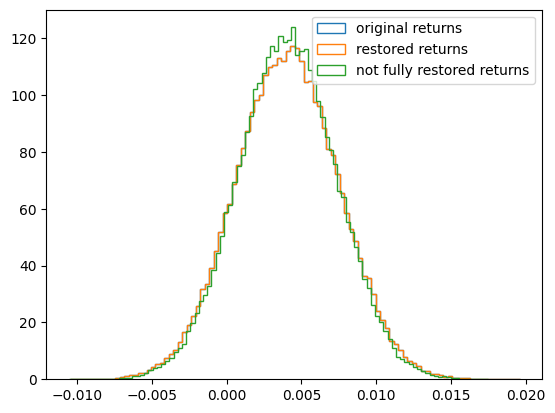

In [178]:
# пример: расчет факторных нагрузок
# примечание: пример подготовлен при помощи LLM

# Factor model construction with NumPy
def construct_factor_model(returns: np.ndarray, factors: np.ndarray) -> tuple:
    """Construct factor model using matrix operations"""
    # Factor loadings via OLS: β = (F'F)^(-1) F'R
    F = factors
    beta = np.linalg.inv(F.T @ F) @ F.T @ returns
    residuals = returns - F @ beta
    return beta.flatten(), residuals.flatten()

# в качестве факторов сгенерируем ряды с матрицей ковариаций covariances и средним вектором means
samples: np.ndarray = np.random.multivariate_normal(mean=means, cov=covariances, size=100_000)

# для приведения к ретурнам, отскалируем на корень из dt и волатильность по каждому фактору
dt = 5.  # 5 лет
sigma = np.asarray([np.sqrt( covariances[i,i] / dt ) for i in range(covariances.shape[0])])
print('sigma:', sigma)

# поменяем масштаб времени и сгенерируем ряды доходностей
dt = 1 / 365.25 / 24 / 60  # 1 минута
factor_returns: np.ndarray = samples * np.sqrt(dt) * sigma

# построим гистограмму факторных доходностей с label по каждому фактору
for i in range(factor_returns.shape[1]):
    plt.hist(factor_returns[:, i], bins=100, density=True, histtype='step', label=f'factor {i}')
plt.legend()
# plt.semilogy()
plt.show()

random_beta = np.random.randn(factor_returns.shape[1], 1)
returns = factor_returns @ random_beta + np.random.normal(loc=0, scale=0.001, size=(factor_returns.shape[0], 1))

# рассчитаем коэффициенты факторной модели
beta, residuals = construct_factor_model(returns, factor_returns)

restored_returns = factor_returns @ beta.T + residuals
not_fully_restored_returns = factor_returns @ beta.T

# построим гистограмму восстановленных доходностей
plt.hist(returns, bins=100, density=True, histtype='step', label='original returns')
plt.hist(restored_returns, bins=100, density=True, histtype='step', label='restored returns')
# plt.hist(residuals, bins=100, density=True, histtype='step', label='residual returns')
plt.hist(not_fully_restored_returns, bins=100, density=True, histtype='step', label='not fully restored returns')
plt.legend()
plt.show()

##### PANDAS

Pandas — программная библиотека на языке Python для обработки и анализа данных. Предоставляет специальные структуры данных и операции для манипулирования числовыми таблицами и временны́ми рядами.

Некоторые возможности библиотеки: можно легко фильтровать, группировать, объединять и преобразовывать данные для конкретных задач.

In [1]:
# рассмотрим данные с мосбиржи - аггрегированные потоки заявок и сделок. Проведем манипуляций и попытаемся что-нибудь найти

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import glob
from tqdm import tqdm

PATH_TO_DATA: str = '/home/dmitry/market_data/moex_features_unified/full/'

paths_to_data: list[str] = sorted(glob.glob(PATH_TO_DATA + '*.parquet'))
fields: list[str] = list(
    map(
        lambda x: x.split('/')[-1].removesuffix('.parquet'),
        sorted(paths_to_data)
    )
)
data: dict[pd.DataFrame] = dict()
for field, path in tqdm(zip(fields, paths_to_data)):
    assert field in path, 'this field is does not map the data!'
    data[field] = pd.read_parquet(path)['2024-01-01':'2025-01-01']


62it [00:01, 50.74it/s]


In [2]:
# normalize returns (clip those with jumps and splits)
import warnings

warnings.filterwarnings('ignore')

tickers_returns = data['trade_pr_vwap'].resample('5min').first().ffill().pct_change().shift(-1)
while tickers_returns.abs().max(axis=0).max() > 0.075:
    arg_max = tickers_returns.abs().max(axis=0).argmax()
    tickers_returns[tickers_returns.abs().max(axis=1) == tickers_returns.abs().max(axis=0)[arg_max]] =\
        tickers_returns[tickers_returns.abs().max(axis=1) == tickers_returns.abs().max(axis=0)[arg_max]].clip(-1e-5, 1e-5)

notna = tickers_returns.notna().mean().sort_values()
valid_tickers = notna[notna > 0.9].index

<Axes: xlabel='Time', ylabel='Cumulative return, PnL'>

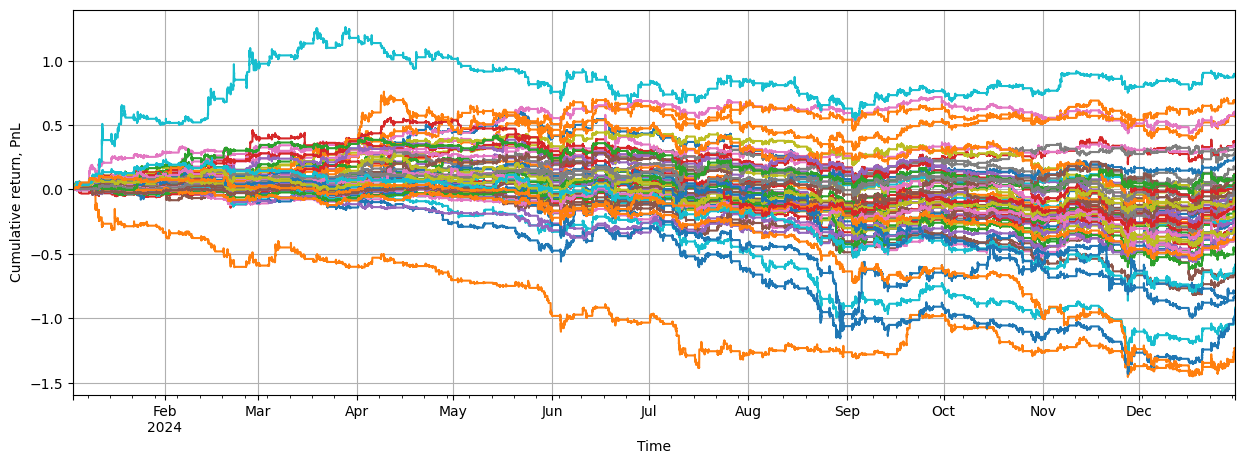

In [3]:
# первое что можно посмотреть -- общие статистики
data['order_cancel_orders'].describe()

# pandas поддерживает отрисовку графиков
tickers_returns['2024-01-01':'2025-01-01'].cumsum().plot(
    figsize=(15,5),
    legend=False,
    grid=True,
    xlabel='Time',
    ylabel='Cumulative return, PnL'
)

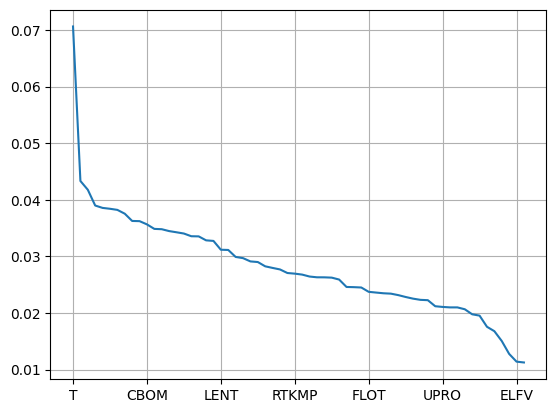

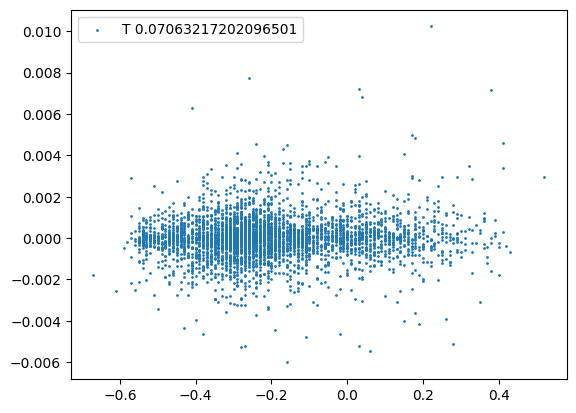

In [5]:
# посмотрим корреляцию между дисбалансом приказов в LOB с будущей корреляцией ретурнов
sorted_by_corr = data['orderbook_imbalance_val'].corrwith(tickers_returns).sort_values(ascending=False)
sorted_by_corr.plot(grid=True)

ticker = sorted_by_corr.index[0]
cidx = tickers_returns[ticker].index.intersection(data['orderbook_imbalance_val'][ticker].index)
plt.figure()
plt.scatter(
    x=data['orderbook_imbalance_val'].loc[cidx, ticker],
    y=tickers_returns.loc[cidx, ticker],
    s=1,
    label=ticker + f' {sorted_by_corr.loc[ticker]}'
)
plt.legend()
plt.show()

In [6]:
# попытаемся предсказывать будущие цены по дисбалансу
# сначала посмотрим, как можно максимизировать корреляцию признака с ретурном

# попытаемся сгладить, усреднить, отранжировать и т.д.

imbalance = data['orderbook_imbalance_val']

print('Base imbalance corr\n', imbalance.corrwith(tickers_returns).mean(), sep='')

ema_smoothed_imb = imbalance.ewm(6).mean()  # экспоненциальное сглаживание в 1 час
print('\nEma 0.5h imbalance corr\n', ema_smoothed_imb.corrwith(tickers_returns).mean(), sep='')

ema_smoothed_imb = imbalance.ewm(12).mean()  # экспоненциальное сглаживание в 1 час
print('\nEma 1h imbalance corr\n', ema_smoothed_imb.corrwith(tickers_returns).mean(), sep='')


mean_smoothed_imb = imbalance.rolling(6).mean()  # сглаживание средним 1 час
print('\nTS mean 0.5h imbalance corr\n', mean_smoothed_imb.corrwith(tickers_returns).mean(), sep='')

mean_smoothed_imb = imbalance.rolling(12).mean()  # сглаживание средним 1 час
print('\nTS mean 1h imbalance corr\n', mean_smoothed_imb.corrwith(tickers_returns).mean(), sep='')


ts_max_imb = imbalance.rolling(6).max()
print('\nTS max 0.5h imbalance corr\n', ts_max_imb.corrwith(tickers_returns).mean(), sep='')

ts_max_imb = imbalance.rolling(12).max()
print('\nTS max 1h imbalance corr\n', ts_max_imb.corrwith(tickers_returns).mean(), sep='')


Base imbalance corr
0.02817896452790021

Ema 0.5h imbalance corr
0.015072924889939615

Ema 1h imbalance corr
0.013744083964397502

TS mean 0.5h imbalance corr
0.016157496829254357

TS mean 1h imbalance corr
0.01390740998741757

TS max 0.5h imbalance corr
0.017265624596735613

TS max 1h imbalance corr
0.015254197803174203


In [18]:
# построим стратегии на этих признаках

def renorm(pf: pd.DataFrame) -> pd.DataFrame:
    pf = pf.sub(pf.mean(axis=1), axis=0)
    pf = pf.div(pf.abs().sum(axis=1), axis=0)
    # assert pf.sum(axis=1).mean() < 1e-10, 'Portfolio must be market neutral!'
    # assert (pf.abs().sum(axis=1) - 1).abs().mean() < 1e-10, 'Portfolio must be market neutral!'
    return pf

# напишем вспомогательные функции

def get_returns_with_costs(pf: pd.DataFrame, tickers_returns: pd.DataFrame, cost: int = 0, sum_tickers: bool = False) -> pd.Series:
    tvr = pf.diff().abs()
    returns = pf * tickers_returns - tvr * cost * 1e-4
    returns = returns[:min(pf.last_valid_index(), tickers_returns.last_valid_index())]
    if sum_tickers:
        return returns.sum(axis=1)
    return returns

def get_pnl_with_costs(pf: pd.DataFrame, tickers_returns: pd.DataFrame, cost: int = 0, sum_tickers: bool = True) -> pd.Series:
    return get_returns_with_costs(pf, tickers_returns, cost, sum_tickers).cumsum()

def get_sharpe(pnl: pd.Series) -> float:
    returns = pnl.diff()
    dt = (returns.index[1] - returns.index[0]) / pd.Timedelta('365D')
    return returns.mean() / (returns.std() + 1e-8) / np.sqrt(dt)

def describe_pf(
    pf: pd.DataFrame, tickers_returns: pd.DataFrame, cost: int = 0, return_as_str: bool = True
) -> dict[str, float] | str:
    returns = get_returns_with_costs(pf, tickers_returns, cost, sum_tickers=False)
    turnover = pf.diff().abs()
    daily_turnover = turnover.sum(axis=1).resample('1D').sum()
    daily_turnover = daily_turnover[daily_turnover > 0].mean()
    profit_margin = returns.sum().sum() / (turnover.sum().sum() + 1e-32) * 1e4
    sharpe = get_sharpe(returns.sum(axis=1).cumsum())
    if return_as_str:
        return f'sharpe={sharpe:.2f}, pm={profit_margin:.2f}, tvr={daily_turnover:.2f}'
    return {'sharpe': sharpe, 'profit_margin': profit_margin, 'daily_turnover': daily_turnover}


In [8]:
imbalance_alpha = renorm( imbalance )
ema_smoothed_imb_alpha = renorm( ema_smoothed_imb )
mean_smoothed_imb_alpha = renorm( mean_smoothed_imb )
ts_max_imb_alpha = renorm( ts_max_imb )

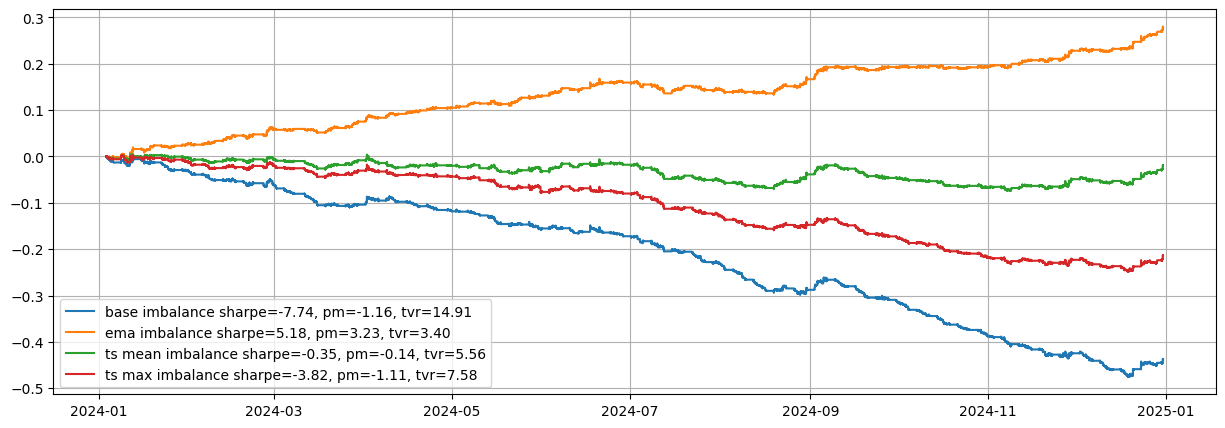

In [9]:
cost = 5

plt.figure(figsize=(15,5))

plt.plot(
    get_pnl_with_costs(imbalance_alpha, tickers_returns, cost=cost), label=f'base imbalance {describe_pf(imbalance_alpha, tickers_returns, cost=cost)}'
)
plt.plot(
    get_pnl_with_costs(ema_smoothed_imb_alpha, tickers_returns, cost=cost), label=f'ema imbalance {describe_pf(ema_smoothed_imb_alpha, tickers_returns, cost=cost)}'
)
plt.plot(
    get_pnl_with_costs(mean_smoothed_imb_alpha, tickers_returns, cost=cost), label=f'ts mean imbalance {describe_pf(mean_smoothed_imb_alpha, tickers_returns, cost=cost)}'
)
plt.plot(
    get_pnl_with_costs(ts_max_imb_alpha, tickers_returns, cost=cost), label=f'ts max imbalance {describe_pf(ts_max_imb_alpha, tickers_returns, cost=cost)}'
)

plt.legend()
plt.grid()

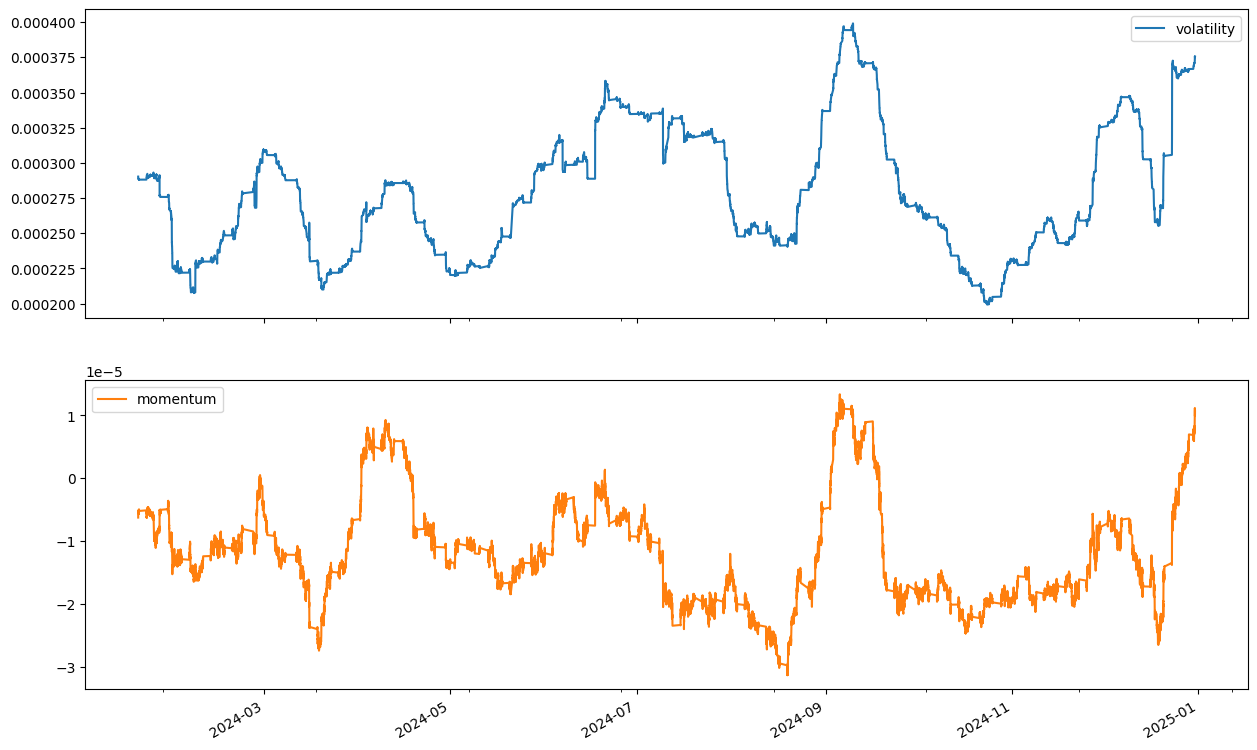

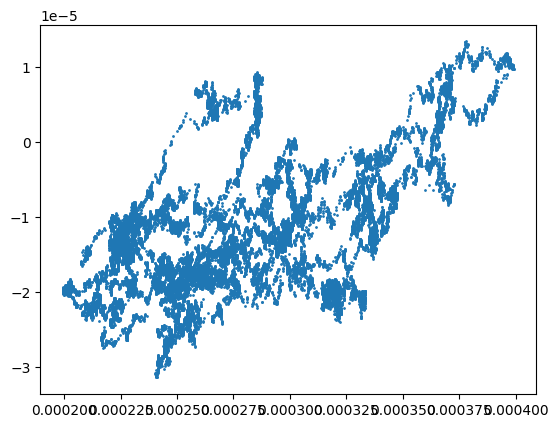

0.5733604981021856


In [10]:
# пример: используя ретурны портфеля на imbalance, найдем разные режимы рынка
# примечание: пример подготовлен при помощи LLM

def regime_detection(returns: pd.Series, window: int = 60) -> pd.DataFrame:
    """Detect market regimes using rolling statistics"""
    regimes = pd.DataFrame(index=returns.index)
    
    # Volatility regime
    regimes['volatility'] = returns.rolling(window).std()
    regimes['vol_regime'] = pd.qcut(regimes['volatility'], 3, labels=['Low', 'Medium', 'High'], duplicates='drop')
    # regimes['vol_regime'] = pd.qcut(regimes['volatility'], 3, labels=['Low', 'High'], duplicates='drop')
    
    # Correlation regime (if multiple assets)
    if isinstance(returns, pd.DataFrame):
        regimes['correlation'] = returns.rolling(window).corr().groupby(level=0).mean()
    
    # Momentum regime
    regimes['momentum'] = returns.rolling(window).mean()
    regimes['momentum_regime'] = np.where(regimes['momentum'] > 0, 'Bull', 'Bear')
    
    return regimes

returns = get_pnl_with_costs(imbalance_alpha, tickers_returns, cost=cost).diff().dropna()
returns = returns[returns.abs() > 1e-10]
regimes = regime_detection(returns, window=12 * 24 * 7)

regimes.plot(subplots=True, figsize=(15, 10))
plt.show()

plt.scatter(regimes['volatility'], regimes['momentum'], s=1)
plt.show()
print(regimes['volatility'].corr(regimes['momentum']))

##### MATPLOTLIB

Matplotlib это обширная библиотека для создания статических, анимированных, и интерактивных визуализаций.

In [1]:
"""
Comprehensive Matplotlib Examples for Quantitative Finance and Physics
====================================================================

This file contains extensive examples of matplotlib usage for:
1. Financial data visualization
2. Statistical analysis
3. Physics simulations
4. Best practices and techniques
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Setup for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

def example_1_time_series_analysis():
    """Example 1: Time series and financial data visualization"""
    print("=== Example 1: Time Series Analysis ===")
    
    # Generate sample data
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', periods=252, freq='D')
    prices = 100 * np.exp(np.cumsum(np.random.normal(0.0005, 0.02, 252)))
    returns = np.diff(np.log(prices))
    volumes = np.random.lognormal(10, 1, 252)
    
    # Create DataFrame
    df = pd.DataFrame({
        'price': prices,
        'volume': volumes
    }, index=dates)
    
    # Create price and volume plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    fig.suptitle('Price and Volume Analysis', fontsize=16, fontweight='bold')
    
    # Price plot
    ax1.plot(df.index, df['price'], linewidth=2, color='blue', label='Price')
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Volume plot
    ax2.bar(df.index, df['volume'], alpha=0.7, color='green', label='Volume')
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def example_2_distribution_analysis():
    """Example 2: Distribution analysis and histograms"""
    print("=== Example 2: Distribution Analysis ===")
    
    # Create different types of distributions
    normal_returns = np.random.normal(0, 0.02, 10000)
    student_t_returns = np.random.standard_t(3, 10000) * 0.02
    laplace_returns = np.random.laplace(0, 0.015, 10000)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Return Distribution Comparison', fontsize=16, fontweight='bold')
    
    # Histograms
    axes[0, 0].hist(normal_returns, bins=50, density=True, alpha=0.7, label='Normal', color='blue')
    axes[0, 0].hist(student_t_returns, bins=50, density=True, alpha=0.7, label='Student-t', color='red')
    axes[0, 0].hist(laplace_returns, bins=50, density=True, alpha=0.7, label='Laplace', color='green')
    axes[0, 0].set_title('Distribution Histograms')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Return')
    axes[0, 0].set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(normal_returns, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot: Normal Distribution')
    
    # Box plot
    data_for_box = [normal_returns, student_t_returns, laplace_returns]
    axes[1, 0].boxplot(data_for_box, labels=['Normal', 'Student-t', 'Laplace'])
    axes[1, 0].set_title('Box Plot Comparison')
    axes[1, 0].set_ylabel('Return')
    
    # Violin plot
    axes[1, 1].violinplot(data_for_box)
    axes[1, 1].set_title('Violin Plot Comparison')
    axes[1, 1].set_xticks([1, 2, 3])
    axes[1, 1].set_xticklabels(['Normal', 'Student-t', 'Laplace'])
    axes[1, 1].set_ylabel('Return')
    
    plt.tight_layout()
    plt.show()

def example_3_correlation_analysis():
    """Example 3: Correlation matrices and heatmaps"""
    print("=== Example 3: Correlation Analysis ===")
    
    # Create correlation matrix for multiple assets
    np.random.seed(42)
    n_assets = 5
    n_days = 252
    
    # Generate correlated returns
    correlation_matrix = np.array([
        [1.0, 0.3, 0.1, -0.2, 0.4],
        [0.3, 1.0, 0.5, 0.1, 0.2],
        [0.1, 0.5, 1.0, 0.3, 0.1],
        [-0.2, 0.1, 0.3, 1.0, -0.1],
        [0.4, 0.2, 0.1, -0.1, 1.0]
    ])
    
    # Create correlated data
    L = np.linalg.cholesky(correlation_matrix)
    uncorrelated_returns = np.random.normal(0, 0.02, (n_days, n_assets))
    correlated_returns = uncorrelated_returns @ L.T
    
    # Create DataFrame
    asset_names = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
    returns_df = pd.DataFrame(correlated_returns, columns=asset_names)
    
    # Calculate correlation matrix
    corr_matrix = returns_df.corr()
    
    # Create heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Asset Correlation Analysis', fontsize=16, fontweight='bold')
    
    # Correlation heatmap
    im1 = ax1.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax1.set_xticks(range(len(asset_names)))
    ax1.set_yticks(range(len(asset_names)))
    ax1.set_xticklabels(asset_names)
    ax1.set_yticklabels(asset_names)
    ax1.set_title('Correlation Matrix')
    
    # Add values to cells
    for i in range(len(asset_names)):
        for j in range(len(asset_names)):
            text = ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im1, ax=ax1)
    
    # Seaborn heatmap for comparison
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=ax2, cbar_kws={'label': 'Correlation'})
    ax2.set_title('Seaborn Heatmap')
    
    plt.tight_layout()
    plt.show()

def example_4_volatility_analysis():
    """Example 4: Volatility analysis and risk metrics"""
    print("=== Example 4: Volatility Analysis ===")
    
    # Create data with different volatility regimes
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', periods=500, freq='D')
    
    # Generate data with volatility clustering
    volatility_regime = np.random.choice([0.01, 0.03, 0.05], size=500, p=[0.6, 0.3, 0.1])
    returns = np.random.normal(0, volatility_regime, 500)
    prices = 100 * np.exp(np.cumsum(returns))
    
    # Calculate rolling volatility
    rolling_vol = pd.Series(returns).rolling(window=30).std() * np.sqrt(252)
    
    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('Volatility and Risk Analysis', fontsize=16, fontweight='bold')
    
    # Price plot
    ax1.plot(dates, prices, linewidth=2, color='blue', label='Price')
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Returns plot
    ax2.plot(dates, returns, alpha=0.7, color='red', label='Returns')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Return', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Volatility plot
    ax3.plot(dates, rolling_vol, linewidth=2, color='green', label='30-day Volatility')
    ax3.fill_between(dates, rolling_vol, alpha=0.3, color='green')
    ax3.set_ylabel('Volatility (Annualized)', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def example_5_portfolio_analysis():
    """Example 5: Portfolio analysis and efficient frontier"""
    print("=== Example 5: Portfolio Analysis ===")
    
    # Create data for portfolio optimization
    np.random.seed(42)
    n_assets = 10
    n_days = 252
    
    # Generate asset returns
    returns_data = np.random.multivariate_normal(
        mean=np.random.uniform(0.05, 0.15, n_assets),
        cov=np.random.uniform(0.1, 0.3, (n_assets, n_assets)) * np.eye(n_assets),
        size=n_days
    )
    
    # Calculate expected returns and covariances
    expected_returns = np.mean(returns_data, axis=0)
    cov_matrix = np.cov(returns_data.T)
    
    # Generate random portfolios
    n_portfolios = 10000
    portfolio_returns = []
    portfolio_volatilities = []
    portfolio_weights = []
    
    for _ in range(n_portfolios):
        weights = np.random.random(n_assets)
        weights = weights / np.sum(weights)
        
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        
        portfolio_returns.append(portfolio_return)
        portfolio_volatilities.append(portfolio_volatility)
        portfolio_weights.append(weights)
    
    # Find optimal portfolio (maximum Sharpe ratio)
    risk_free_rate = 0.02
    sharpe_ratios = (np.array(portfolio_returns) - risk_free_rate) / np.array(portfolio_volatilities)
    optimal_idx = np.argmax(sharpe_ratios)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Portfolio Analysis and Efficient Frontier', fontsize=16, fontweight='bold')
    
    # Efficient frontier
    scatter = ax1.scatter(portfolio_volatilities, portfolio_returns, 
                         c=sharpe_ratios, cmap='viridis', alpha=0.6, s=20)
    ax1.scatter(portfolio_volatilities[optimal_idx], portfolio_returns[optimal_idx], 
               color='red', s=100, marker='*', label='Optimal Portfolio')
    ax1.set_xlabel('Volatility', fontsize=12)
    ax1.set_ylabel('Expected Return', fontsize=12)
    ax1.set_title('Efficient Frontier')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Sharpe Ratio')
    
    # Optimal portfolio weights
    asset_names = [f'Asset_{i+1}' for i in range(n_assets)]
    bars = ax2.bar(asset_names, portfolio_weights[optimal_idx], alpha=0.7)
    ax2.set_xlabel('Assets', fontsize=12)
    ax2.set_ylabel('Portfolio Weight', fontsize=12)
    ax2.set_title('Optimal Portfolio Weights')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add values on bars
    for bar, weight in zip(bars, portfolio_weights[optimal_idx]):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{weight:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def example_6_physics_simulations():
    """Example 6: Physics simulations - harmonic oscillator and waves"""
    print("=== Example 6: Physics Simulations ===")
    
    # Harmonic oscillator with damping
    def harmonic_oscillator(t, A=1.0, omega=2*np.pi, gamma=0.1, phi=0):
        """Harmonic oscillator with damping"""
        return A * np.exp(-gamma * t) * np.cos(omega * t + phi)
    
    # Wave equation
    def wave_function(x, t, k=2*np.pi, omega=2*np.pi, A=1.0):
        """Wave function"""
        return A * np.sin(k * x - omega * t)
    
    # Create data
    t = np.linspace(0, 10, 1000)
    x = np.linspace(0, 4*np.pi, 200)
    
    # Create plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Physics Examples: Oscillators and Waves', fontsize=16, fontweight='bold')
    
    # Harmonic oscillator
    ax1.plot(t, harmonic_oscillator(t), linewidth=2, color='blue', label='No Damping')
    ax1.plot(t, harmonic_oscillator(t, gamma=0.2), linewidth=2, color='red', label='With Damping')
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.set_title('Harmonic Oscillator')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Phase portrait
    t_phase = np.linspace(0, 20, 2000)
    x_phase = harmonic_oscillator(t_phase, gamma=0.1)
    v_phase = -harmonic_oscillator(t_phase, gamma=0.1, phi=np.pi/2) * 2*np.pi
    ax2.plot(x_phase, v_phase, linewidth=2, color='purple')
    ax2.set_xlabel('Position', fontsize=12)
    ax2.set_ylabel('Velocity', fontsize=12)
    ax2.set_title('Phase Portrait')
    ax2.grid(True, alpha=0.3)
    
    # Wave function at different times
    for i, time in enumerate([0, 1, 2, 3]):
        wave = wave_function(x, time)
        ax3.plot(x, wave, linewidth=2, label=f't = {time}s', alpha=0.7)
    ax3.set_xlabel('Position', fontsize=12)
    ax3.set_ylabel('Amplitude', fontsize=12)
    ax3.set_title('Wave Function')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 3D wave plot
    X, T = np.meshgrid(x, t[:50])
    Z = wave_function(X, T)
    
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf = ax4.plot_surface(X, T, Z, cmap='viridis', alpha=0.8)
    ax4.set_xlabel('Position', fontsize=12)
    ax4.set_ylabel('Time', fontsize=12)
    ax4.set_zlabel('Amplitude', fontsize=12)
    ax4.set_title('3D Wave Function')
    
    plt.tight_layout()
    plt.show()

def example_7_candlestick_charts():
    """Example 7: Specialized financial charts - candlestick"""
    print("=== Example 7: Candlestick Charts ===")
    
    # Create OHLC data
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', periods=50, freq='D')
    
    # Generate OHLC data
    base_price = 100
    prices = []
    for _ in range(50):
        open_price = base_price + np.random.normal(0, 2)
        close_price = open_price + np.random.normal(0, 3)
        high_price = max(open_price, close_price) + abs(np.random.normal(0, 1))
        low_price = min(open_price, close_price) - abs(np.random.normal(0, 1))
        
        prices.append([open_price, high_price, low_price, close_price])
        base_price = close_price
    
    ohlc_data = pd.DataFrame(prices, columns=['Open', 'High', 'Low', 'Close'], index=dates)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle('Specialized Financial Charts', fontsize=16, fontweight='bold')
    
    # Candlestick chart
    for i, (date, row) in enumerate(ohlc_data.iterrows()):
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        
        # Candle body
        body_height = abs(row['Close'] - row['Open'])
        body_bottom = min(row['Open'], row['Close'])
        
        rect = Rectangle((i-0.3, body_bottom), 0.6, body_height, 
                        facecolor=color, edgecolor='black', alpha=0.7)
        ax1.add_patch(rect)
        
        # Shadows
        ax1.plot([i, i], [row['Low'], row['High']], color='black', linewidth=1)
    
    ax1.set_xlim(-1, len(ohlc_data))
    ax1.set_ylabel('Price', fontsize=12)
    ax1.set_title('Candlestick Chart')
    ax1.grid(True, alpha=0.3)
    
    # Volume chart (simulation)
    volumes = np.random.lognormal(10, 1, len(ohlc_data))
    colors = ['green' if close >= open else 'red' 
              for open, close in zip(ohlc_data['Open'], ohlc_data['Close'])]
    
    ax2.bar(range(len(volumes)), volumes, color=colors, alpha=0.7)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_title('Trading Volume')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def example_8_statistical_analysis():
    """Example 8: Statistical analysis and data visualization"""
    print("=== Example 8: Statistical Analysis ===")
    
    # Create comprehensive statistical analysis
    np.random.seed(42)
    
    # Generate data with outliers
    normal_data = np.random.normal(0, 1, 1000)
    outliers = np.random.normal(0, 5, 50)
    data_with_outliers = np.concatenate([normal_data, outliers])
    
    # Create plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Statistical Data Analysis', fontsize=16, fontweight='bold')
    
    # Histogram with density curve
    ax1.hist(data_with_outliers, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    x_range = np.linspace(data_with_outliers.min(), data_with_outliers.max(), 100)
    ax1.plot(x_range, stats.norm.pdf(x_range, 0, 1), 'r-', linewidth=2, label='Normal Distribution')
    ax1.set_xlabel('Value', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Histogram with Density')
    ax1.legend()
    
    # Box plot with outliers
    ax2.boxplot([normal_data, data_with_outliers], labels=['No Outliers', 'With Outliers'])
    ax2.set_ylabel('Value', fontsize=12)
    ax2.set_title('Box Plot Comparison')
    
    # Q-Q plot
    stats.probplot(data_with_outliers, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot for Data with Outliers')
    
    # Scatter plot with regression
    x_reg = np.random.normal(0, 1, 200)
    y_reg = 2 * x_reg + np.random.normal(0, 0.5, 200)
    
    ax4.scatter(x_reg, y_reg, alpha=0.6, color='blue')
    z = np.polyfit(x_reg, y_reg, 1)
    p = np.poly1d(z)
    ax4.plot(x_reg, p(x_reg), "r--", linewidth=2, label=f'Regression: y = {z[0]:.2f}x + {z[1]:.2f}')
    ax4.set_xlabel('X', fontsize=12)
    ax4.set_ylabel('Y', fontsize=12)
    ax4.set_title('Regression Analysis')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

def print_best_practices():
    """Print matplotlib best practices"""
    print("""
=== MATPLOTLIB BEST PRACTICES ===

1. STYLE AND FORMATTING:
   - Use plt.style.use() for consistent styling
   - Set figsize to control plot size
   - Add titles, axis labels, and legends
   - Use grid for better readability

2. COLORS AND PALETTES:
   - Use semantically meaningful colors
   - Apply alpha for transparency
   - Use color maps for continuous data
   - Consider color blindness (use viridis, plasma)

3. PLOT TYPES:
   - Line plots for time series
   - Scatter plots for correlations
   - Histograms for distributions
   - Box plots for group comparisons
   - Heatmaps for matrices

4. PERFORMANCE:
   - Use vectorized operations
   - Avoid loops in plotting
   - Use subplots for multiple plots
   - Save in vector formats (PDF, SVG)

5. INTERACTIVITY:
   - Use FuncAnimation for animations
   - Consider plotly for interactive plots
   - Add hover effects and zoom

6. EXPORT AND PUBLICATION:
   - Use dpi=300 for high quality
   - Save in multiple formats
   - Consider file sizes
""")

def run_all_examples():
    """Run all matplotlib examples"""
    print("Starting Matplotlib Examples...\n")
    
    try:
        example_1_time_series_analysis()
        example_2_distribution_analysis()
        example_3_correlation_analysis()
        example_4_volatility_analysis()
        example_5_portfolio_analysis()
        example_6_physics_simulations()
        example_7_candlestick_charts()
        example_8_statistical_analysis()
        
        print_best_practices()
        
        print("\nAll examples completed successfully!")
        
    except Exception as e:
        print(f"Error running examples: {e}")

=== Example 8: Statistical Analysis ===


/tmp/ipykernel_27440/1800298105.py:433: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([normal_data, data_with_outliers], labels=['No Outliers', 'With Outliers'])


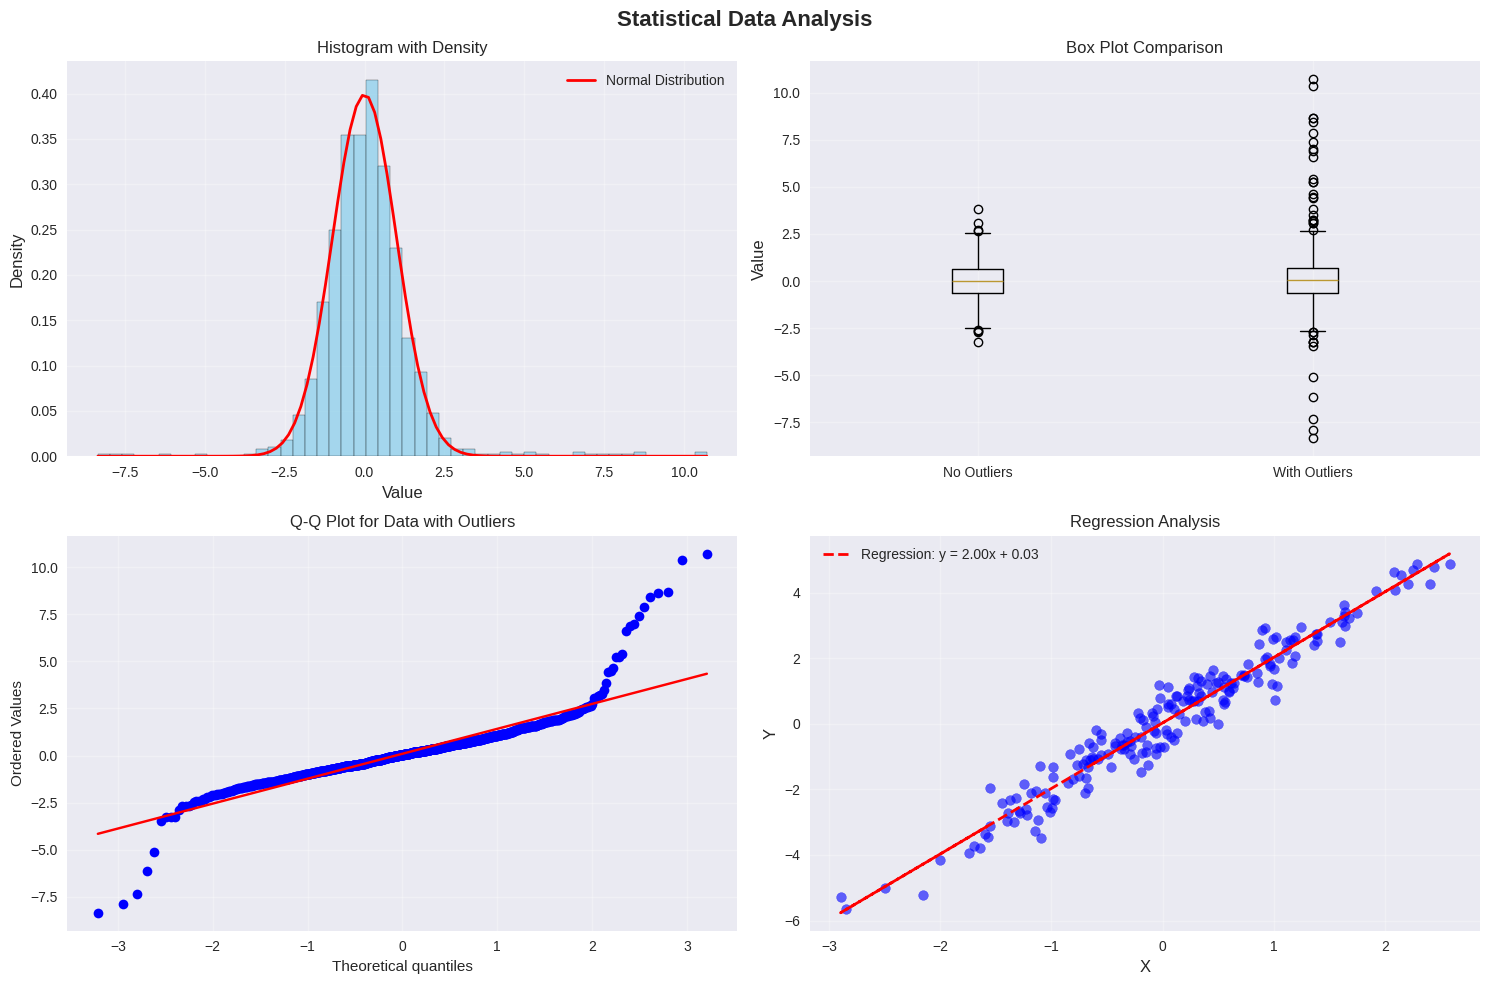

In [10]:
example_8_statistical_analysis()